In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
# 中文
plt.rcParams['font.sans-serif'] = ['SimHei']
# -号
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("../metadata/celebrity_name.json", "r", encoding="utf-8") as f:
    names = json.load(f)

In [4]:
pd.DataFrame(names).to_csv("../metadata/celebrity_name.csv", index=False, encoding="utf-8-sig")

In [3]:
with open("../metadata/celebrity_MaoYan.json", "r", encoding="utf-8") as f:
    data_maoyan = json.load(f)

In [4]:
data_maoyan[0:5]

[{'姓名': '吴涵伊', 'uid': 1, '总票房': 3280000.0, '获奖详情': []},
 {'姓名': '杨家麟', 'uid': 2, '总票房': 60000.0, '获奖详情': []},
 {'姓名': '寿美菜子', 'uid': 3, '总票房': 188000000.0, '获奖详情': []},
 {'姓名': '林莉', 'uid': 4, '总票房': -1, '获奖详情': []},
 {'姓名': '顾美华',
  'uid': 5,
  '总票房': 244000000.0,
  '获奖详情': [{'获奖基本信息': {'获奖封面': 'https://p1.meituan.net/movie/93c7e76ea0613b230023c7f0348e77327514.jpg@128w_128h_1e_1c',
     '获奖名称': '香港金像奖',
     '获奖次数': '获奖1次 , 提名2次'},
    '获奖详情': [['第9届-最佳女配角(提名)', '《不脱袜的人》 1989 / 饰:顾太太'],
     ['第4届-最佳新演员', '《似水流年》 1984 / 饰:张珊珊'],
     ['第4届-最佳女主角(提名)', '《似水流年》 1984 / 饰:张珊珊']]},
   {'获奖基本信息': {'获奖封面': 'https://p1.meituan.net/movie/b4fee6afd042d546bd8ec85605a64d385478.jpg@128w_128h_1e_1c',
     '获奖名称': '台湾电影金马奖',
     '获奖次数': '获奖1次'},
    '获奖详情': [['第29届-最佳女配角', "《浮世恋曲》 1992 / 饰:张文娴 Teresa, Tony's wife"]]},
   {'获奖基本信息': {'获奖封面': 'https://p1.meituan.net/moviemachine/067af64bab9bfd5c3b566ffc14f247ee10572.jpg@128w_128h_1e_1c',
     '获奖名称': '上海国际电影节',
     '获奖次数': '获奖1次'},
    '获奖详情': [['第7

In [5]:
# filter items with exist False
data_maoyan = list(filter(lambda x: "exist" not in x, data_maoyan))

In [6]:
f"共存在合法演员信息 {len(data_maoyan)} 条"

'共存在合法演员信息 7745 条'

In [7]:
# to dataframe
df_maoyan = pd.json_normalize(data_maoyan)

In [8]:
df_maoyan.head()

,姓名,uid,总票房,获奖详情
0,吴涵伊,1,3280000.0,[]
1,杨家麟,2,60000.0,[]
2,寿美菜子,3,188000000.0,[]
3,林莉,4,-1.0,[]
4,顾美华,5,244000000.0,[{'获奖基本信息': {'获奖封面': 'https://p1.meituan.net/m...


---

In [9]:
with open("../metadata/celebrity_AiMan.json", "r", encoding="utf-8") as f:
    data_aiman = json.load(f)

In [10]:
df_aiman = pd.json_normalize(data_aiman)

In [11]:
df_aiman.columns = ['商业价值', '代言指数', '热度指数', '口碑指数', '专业指数', '姓名', 'uid']

In [12]:
df_aiman.head()

,商业价值,代言指数,热度指数,口碑指数,专业指数,姓名,uid
0,19.9050,15.3850,4.51,0.000,28.1950,吴涵伊,1
1,27.7875,15.3850,0.00,0.000,38.3175,杨家麟,2
2,48.1975,15.3850,3.99,1.770,61.3975,寿美菜子,3
3,44.3725,29.8225,26.21,2.845,46.8000,林莉,4
4,0.0000,0.0000,0.00,0.000,0.0000,顾美华,5


---

In [13]:
# merge two dataframe
df = pd.merge(df_maoyan, df_aiman, on="uid", how="outer")

In [14]:
# drop row with NaN
df = df.dropna(axis=0, how="any")

In [15]:
# drop row with 总票房==-1
df = df[df["总票房"] != -1]

In [16]:
f"共存在合法演员信息 {df.shape[0]} 条"

'共存在合法演员信息 1445 条'

In [17]:
df["总票房.log"] = df["总票房"].apply(lambda x: np.log(x))

<Axes: ylabel='Frequency'>

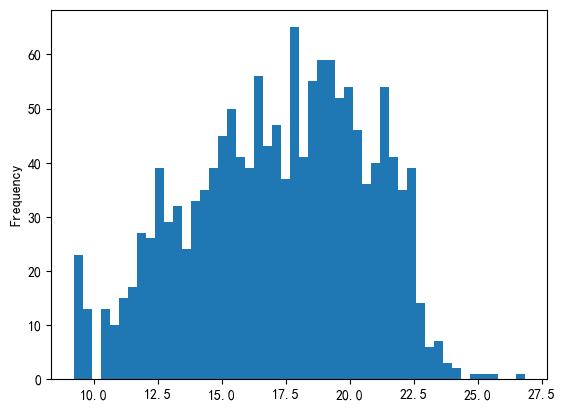

In [18]:
df["总票房.log"].plot.hist(bins=50)

In [20]:
df['获奖详情.数量'] = df['获奖详情'].apply(lambda x: len(x))

In [21]:
numerical_features = ['商业价值', '代言指数', '热度指数', '口碑指数', '专业指数', '总票房.log']
# 做【0，10】标准化
df[numerical_features] = df[numerical_features].apply(lambda x: (x - x.min()) / (x.max() - x.min()) * 10)

<Axes: ylabel='Frequency'>

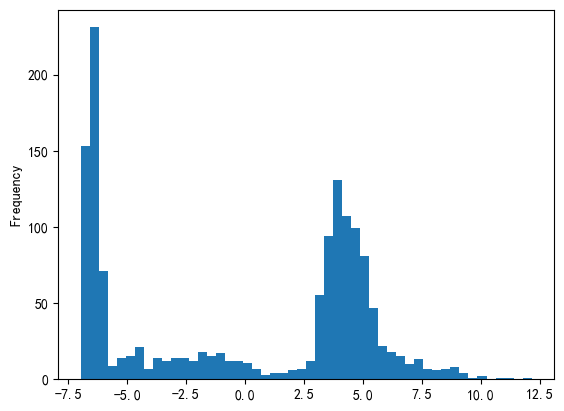

In [22]:
"""
使用主成分分析法进行降维，
将numerical_features中的7个特征降维到1个特征
该特征的大小表示该演员的综合评分
"""


from sklearn.decomposition import PCA

features = ['商业价值', '代言指数', '热度指数', '口碑指数', '专业指数', '获奖详情.数量', '总票房.log']

pca = PCA(n_components=1)
df['综合评分'] = pca.fit_transform(df[numerical_features])

df['综合评分'].plot.hist(bins=50)



In [23]:
# 选取综合评分前10的演员
df = df.sort_values(by="综合评分", ascending=False).reset_index(drop=True)
df.head(5)

,姓名_x,uid,总票房,获奖详情,商业价值,代言指数,热度指数,口碑指数,专业指数,姓名_y,总票房.log,获奖详情.数量,综合评分
0,肖战,262,2.889000e+09,[],10.000000,10.000000,10.000000,10.000000,10.000000,肖战,7.136498,0,12.164831
1,杨颖,913,9.684000e+09,[{'获奖基本信息': {'获奖封面': 'https://p0.meituan.net/m...,9.409239,9.296314,9.352887,9.236410,9.565217,杨颖,7.823007,4,11.239637
2,赵丽,2366,2.347000e+07,[],9.289699,8.874670,9.207138,9.410475,9.651604,赵丽,4.404829,0,10.711958
3,虞书欣,1569,1.052000e+09,[{'获奖基本信息': {'获奖封面': 'https://p0.meituan.net/m...,8.882233,8.635541,8.517794,8.859574,9.238204,虞书欣,6.563131,1,10.199795
4,黄明昊,138,2.600000e+08,[],8.795599,8.669407,7.772570,8.728829,9.415253,黄明昊,5.769805,0,10.032037


In [24]:
# 根据【综合评分】经行tier划分
# tier1: top 5%
# tier2: 5% - 20%
# tier3: 20% - 60%
# tier4: 60% - 100%

def tier(x):
    if x > df["综合评分"].quantile(0.95):
        return 1
    elif x > df["综合评分"].quantile(0.8):
        return 2
    elif x > df["综合评分"].quantile(0.4):
        return 3
    else:
        return 4

df["tier"] = df["综合评分"].apply(tier)
df.head(5)

,姓名_x,uid,总票房,获奖详情,商业价值,代言指数,热度指数,口碑指数,专业指数,姓名_y,总票房.log,获奖详情.数量,综合评分,tier
0,肖战,262,2.889000e+09,[],10.000000,10.000000,10.000000,10.000000,10.000000,肖战,7.136498,0,12.164831,1
1,杨颖,913,9.684000e+09,[{'获奖基本信息': {'获奖封面': 'https://p0.meituan.net/m...,9.409239,9.296314,9.352887,9.236410,9.565217,杨颖,7.823007,4,11.239637,1
2,赵丽,2366,2.347000e+07,[],9.289699,8.874670,9.207138,9.410475,9.651604,赵丽,4.404829,0,10.711958,1
3,虞书欣,1569,1.052000e+09,[{'获奖基本信息': {'获奖封面': 'https://p0.meituan.net/m...,8.882233,8.635541,8.517794,8.859574,9.238204,虞书欣,6.563131,1,10.199795,1
4,黄明昊,138,2.600000e+08,[],8.795599,8.669407,7.772570,8.728829,9.415253,黄明昊,5.769805,0,10.032037,1


In [23]:
df.drop('姓名_y', axis=1, inplace=True)

In [25]:
df.to_excel("./celebrity.xlsx", index=False)